# **Import Libraries**

In [1]:
import pandas as pd  
pd.options.mode.chained_assignment = None  
import numpy as np 
seed = 0
np.random.seed(seed)  
import matplotlib.pyplot as plt  
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 

import datetime as dt 

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory 

# **Data Loading and Cleaning**

In [2]:
df = pd.read_csv('app_review_tiktok.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103500 entries, 0 to 103499
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              103500 non-null  object
 1   userName              103500 non-null  object
 2   userImage             103500 non-null  object
 3   content               103500 non-null  object
 4   score                 103500 non-null  int64 
 5   thumbsUpCount         103500 non-null  int64 
 6   reviewCreatedVersion  75272 non-null   object
 7   at                    103500 non-null  object
 8   replyContent          3444 non-null    object
 9   repliedAt             3444 non-null    object
 10  appVersion            75272 non-null   object
dtypes: int64(2), object(9)
memory usage: 8.7+ MB


In [3]:
df.shape

(103500, 11)

In [4]:
review = df[['content']].copy()
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103500 entries, 0 to 103499
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  103500 non-null  object
dtypes: object(1)
memory usage: 808.7+ KB


In [5]:
review.duplicated().sum()

np.int64(69)

In [6]:
review = review.drop_duplicates()
review.duplicated().sum()

np.int64(0)

In [7]:
reviews = review.sample(n=50000, random_state=32).reset_index(drop=True)
pd.set_option('display.max_colwidth', None)
reviews.head(100)

,content
0,"aplikasi sering bug dan hp langsung mulai ulang, harus sering hapus dan download lagi"
1,"Bagus cuma kadang ga bisa di update, sekali nya di hapus terus download lagi emang udah ke update cuma kalo apk nya di tutup balek lagi jadi update sebelum nya"
2,"Kpda cs tik tok,knpa sya gk bisa login ke akun utama sya yg dlu.di akun itu sya susah payah mendapat kn folower.(Kenapa sya tidak dapat menggirim otp ke email sya,pdhal sya sdah me masuk kn email dnggn benar knpa di bisa menerima otp,tolong bantu sya.please help me"
3,"Aku lumayan sukaya sama apk ini,kenapa sih aku kalau buat video pasti gk ada yang ngelike,tolong perbarui apk ini nanti aku kasih bintang lima,Terima kasih🙏"
4,"pas mau liat video yg disimpan atau lagi scroll kadang suka ngefreeze videonya, padahal jaringan bagus, penyimpanan pun aman, semoga aja ini didengar"
...,...
95,"Orang : bermanfaat dan berguna, alhamdulilah 👍🤲🏻🥺"
96,"Sampek capet yg download aplikasi ini ,tiap mau buka pasti harus download lagi"
97,"Didalam aplikasi ini banyak sekali yang sesat-sesat, dan banyak banget cewek-cewek bohay dan robrut tiktok juga banyak anak-anak jadinya jangan upload video joget-joget ya kakak-kakak 🙏🙏"
98,kenapa setelah update pasti selalu stuck logo saja jadi macet dan gabisa diapain² lagi


# **Data Preprocessing**

### **Functions for data preprocessing**

In [ ]:
import re
import unicodedata
import string
import json
import requests
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
nltk.download('stopwords')
nltk.download('punkt')

def cleaningText(text):
    text = unicodedata.normalize('NFKC', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)  
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)
    text = re.sub(r"http\S+", '', text) 
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[,.\/]', ' ', text) # ubah tanda baca jadi spasi
    text = re.sub(r'[^\w\s]', ' ', text) # hapus simbol non-alfanumerik
    text = re.sub(r'[²]+', '', text) 
    text = text.replace('\n', ' ') 
    text = re.sub(r'\s+', ' ', text).strip() # hapus spasi ganda
    text = text.translate(str.maketrans('', '', string.punctuation))  # hapus tanda baca sisa
    text = text.strip()
    return text

def casefoldingText(text):
    return text.lower()

def tokenizingText(text):
    return word_tokenize(text)

def filteringText(words):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords.update(stopwords.words('english'))
    listStopwords.update([
        'iya', 'yaa', 'gak', 'nya', 'na', 'sih', 'ku', 'mah', 'kak', 'bolak', 'nge', 'nih', 'deh', 
        'loh', 'yah', 'wkwk', 'hihi', 'hehe', 'hahaha', 'gitu', 'nge', 'trus', 'terus', 'orang', 'logo',
        'hehehe', 'wkwkwk', 'yuk', 'dong', 'loh', 'yah', 'kok', 'gue', 'loh', 'si', 'siapa',
        'di', 'ga', 'ya', 'gaa', 'loh', 'kah', 'woi', 'woii', 'woy', 'tuh', 'tiktok'
    ])

    listStopwords = [w for w in listStopwords if w not in ['tidak', 'bukan', 'kurang']]
    filtered = [word for word in words if word not in listStopwords]
    return filtered

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_corpus(corpus):
    unique_words = set(' '.join(corpus).split())
    stem_dict = {w: stemmer.stem(w) for w in unique_words}
    return [' '.join(stem_dict[w] for w in text.split()) for text in corpus]

def toSentence(list_words):
    return ' '.join(list_words)

url = "https://raw.githubusercontent.com/laventilizz/analisis_sentimen_app/main/slangwords.json"

response = requests.get(url)
slangwords = response.json()

def fix_slangwords(text):
    words = text.split()
    fixed_words = [slangwords.get(word.lower(), word) for word in words]
    return ' '.join(fixed_words)

def handle_negation(text):
    words = text.split()
    new_words = []
    skip_next = False
    for i in range(len(words)):
        if skip_next:
            skip_next = False
            continue
        if words[i] in ['tidak', 'gak', 'nggak', 'bukan', 'kurang'] and i+1 < len(words):
            new_words.append(words[i] + '_' + words[i+1])  # jadi "tidak_profesional"
            skip_next = True
        else:
            new_words.append(words[i])
    return ' '.join(new_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### **Apply functions to data**

In [10]:
reviews['text_clean'] = reviews['content'].apply(cleaningText)
reviews['text_casefoldingText'] = reviews['text_clean'].apply(casefoldingText)
reviews['text_slangwords'] = reviews['text_casefoldingText'].apply(fix_slangwords)
reviews['text_negation'] = reviews['text_slangwords'].apply(handle_negation)
reviews['text_tokenizingText'] = reviews['text_negation'].apply(tokenizingText)
reviews['text_stopword'] = reviews['text_tokenizingText'].apply(filteringText)
reviews['text_akhir'] = reviews['text_stopword'].apply(toSentence)

In [15]:
reviews.head()

,content,text_clean,text_casefoldingText,text_slangwords,text_negation,text_tokenizingText,text_stopword,text_akhir
0,"aplikasi sering bug dan hp langsung mulai ulang, harus sering hapus dan download lagi",aplikasi sering bug dan hp langsung mulai ulang harus sering hapus dan download lagi,aplikasi sering bug dan hp langsung mulai ulang harus sering hapus dan download lagi,aplikasi sering galat dan ponsel langsung mulai ulang harus sering hapus dan unduh lagi,aplikasi sering galat dan ponsel langsung mulai ulang harus sering hapus dan unduh lagi,"[aplikasi, sering, galat, dan, ponsel, langsung, mulai, ulang, harus, sering, hapus, dan, unduh, lagi]","[aplikasi, galat, ponsel, langsung, ulang, hapus, unduh]",aplikasi galat ponsel langsung ulang hapus unduh
1,"Bagus cuma kadang ga bisa di update, sekali nya di hapus terus download lagi emang udah ke update cuma kalo apk nya di tutup balek lagi jadi update sebelum nya",Bagus cuma kadang ga bisa di update sekali nya di hapus terus download lagi emang udah ke update cuma kalo apk nya di tutup balek lagi jadi update sebelum nya,bagus cuma kadang ga bisa di update sekali nya di hapus terus download lagi emang udah ke update cuma kalo apk nya di tutup balek lagi jadi update sebelum nya,bagus hanya kadang tidak bisa di perbarui sekali nya di hapus terus unduh lagi memang sudah ke perbarui hanya kalau aplikasi nya di tutup balek lagi jadi perbarui sebelum nya,bagus hanya kadang tidak_bisa di perbarui sekali nya di hapus terus unduh lagi memang sudah ke perbarui hanya kalau aplikasi nya di tutup balek lagi jadi perbarui sebelum nya,"[bagus, hanya, kadang, tidak_bisa, di, perbarui, sekali, nya, di, hapus, terus, unduh, lagi, memang, sudah, ke, perbarui, hanya, kalau, aplikasi, nya, di, tutup, balek, lagi, jadi, perbarui, sebelum, nya]","[bagus, kadang, tidak_bisa, perbarui, hapus, unduh, perbarui, aplikasi, tutup, balek, perbarui]",bagus kadang tidak_bisa perbarui hapus unduh perbarui aplikasi tutup balek perbarui
2,"Kpda cs tik tok,knpa sya gk bisa login ke akun utama sya yg dlu.di akun itu sya susah payah mendapat kn folower.(Kenapa sya tidak dapat menggirim otp ke email sya,pdhal sya sdah me masuk kn email dnggn benar knpa di bisa menerima otp,tolong bantu sya.please help me",Kpda cs tik tok knpa sya gk bisa login ke akun utama sya yg dlu di akun itu sya susah payah mendapat kn folower Kenapa sya tidak dapat menggirim otp ke email sya pdhal sya sdah me masuk kn email dnggn benar knpa di bisa menerima otp tolong bantu sya please help me,kpda cs tik tok knpa sya gk bisa login ke akun utama sya yg dlu di akun itu sya susah payah mendapat kn folower kenapa sya tidak dapat menggirim otp ke email sya pdhal sya sdah me masuk kn email dnggn benar knpa di bisa menerima otp tolong bantu sya please help me,kpda cs tiktok tiktok kenapa saya tidak bisa login ke akun utama saya yang dulu di akun itu saya susah payah mendapat kan pengikut kenapa saya tidak dapat menggirim otp ke surel saya padahal saya sdah me masuk kan surel dnggn benar kenapa di bisa menerima otp tolong bantu saya tolong tolong me,kpda cs tiktok tiktok kenapa saya tidak_bisa login ke akun utama saya yang dulu di akun itu saya susah payah mendapat kan pengikut kenapa saya tidak_dapat menggirim otp ke surel saya padahal saya sdah me masuk kan surel dnggn benar kenapa di bisa menerima otp tolong bantu saya tolong tolong me,"[kpda, cs, tiktok, tiktok, kenapa, saya, tidak_bisa, login, ke, akun, utama, saya, yang, dulu, di, akun, itu, saya, susah, payah, mendapat, kan, pengikut, kenapa, saya, tidak_dapat, menggirim, otp, ke, surel, saya, padahal, saya, sdah, me, masuk, kan, surel, dnggn, benar, kenapa, di, bisa, menerima, otp, tolong, bantu, saya, tolong, tolong, me]","[kpda, cs, tidak_bisa, login, akun, utama, akun, susah, payah, pengikut, tidak_dapat, menggirim, otp, surel, sdah, masuk, surel, dnggn, menerima, otp, tolong, bantu, tolong, tolong]",kpda cs tidak_bisa login akun utama akun susah payah pengikut tidak_dapat menggirim otp sur

# **Labelling**

In [16]:
import requests
import csv
from io import StringIO

lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/fajri91/Inset/master/positive.tsv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter='\t')
    next(reader)  

    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/fajri91/Inset/master/negative.tsv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter='\t')
    next(reader)  

    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

In [16]:
import csv

lexicon_positive = {}
try:
    with open('lexicon_positive.csv', encoding='utf-8') as f:
        reader = csv.reader(f, delimiter=';')  # pakai ; karena isi file pakai titik koma
        for row in reader:
            try:
                lexicon_positive[row[0].strip()] = int(float(row[1].replace(',', '.')))
            except ValueError as ve:
                print(f"Baris invalid dilewati: {row} - Error: {ve}")
except FileNotFoundError:
    print("File lexicon_positive.csv tidak ditemukan.")


lexicon_negative = {}
try:
    with open('lexicon_negative.csv', encoding='utf-8') as f:
        reader = csv.reader(f, delimiter=';')  # pakai ; karena isi file pakai titik koma
        for row in reader:
            try:
                lexicon_positive[row[0].strip()] = int(float(row[1].replace(',', '.')))
            except ValueError as ve:
                print(f"Baris invalid dilewati: {row} - Error: {ve}")
except FileNotFoundError:
    print("File lexicon_positive.csv tidak ditemukan.")


In [17]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
    
    polarity=''
    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [18]:
results = reviews['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
reviews['polarity_score'] = results[0]
reviews['polarity'] = results[1]
print(reviews['polarity'].value_counts())

polarity
negative    33111
positive    12605
neutral      4284
Name: count, dtype: int64


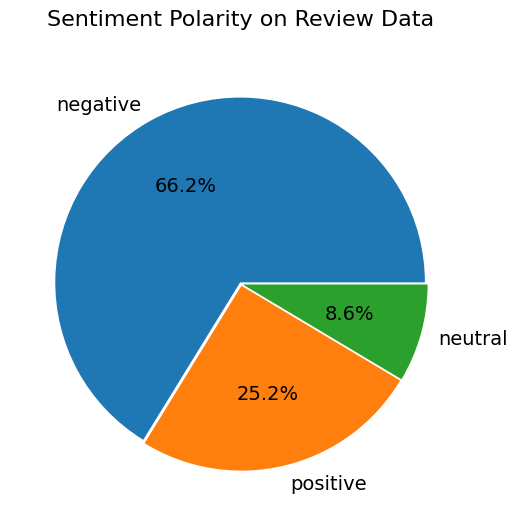

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))

sizes = [count for count in reviews['polarity'].value_counts()]
labels = list(reviews['polarity'].value_counts().index)
explode = [0.01] * len(labels)

# autopct = shows percentage inside the pie
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})

ax.set_title('Sentiment Polarity on Review Data', fontsize=16, pad=20)
plt.show()

### **Make DataFrame for Each Polarity**

In [20]:
# Membuat DataFrame baru 'positive_reviews' yang hanya berisi review dengan polaritas positif.
positive_reviews = reviews[reviews['polarity'] == 'positive']
positive_reviews = positive_reviews[['content','text_akhir', 'polarity_score', 'polarity']]
positive_reviews = positive_reviews.sort_values(by='polarity_score', ascending=False)
positive_reviews = positive_reviews.reset_index(drop=True)
positive_reviews.index += 1
positive_reviews.head()

,content,text_akhir,polarity_score,polarity
1,"Terus dukung akun-akun yang kreatif yang mengasih maanfaat buat orang banyak, kalo sekiranya itu kreatif dan bermanfaat tolong tayagin selama-lamanya dan sebanyak-banyaknya, karena mencari ide kreatif yang berilmu itu sulit, jadi tolong hargai karya konten kreator. Terimakasih",dukung akun akun kreatif mengasih maanfaat kreatif bermanfaat tolong tayagin banyaknya mencari ide kreatif berilmu sulit tolong harga karya konten pencipta terima kasih,36,positive
2,"TikTok adalah platform media sosial berbasis video pendek yang memungkinkan pengguna mengekspresikan kreativitas mereka melalui musik, tarian, komedi, hingga konten edukasi. Aplikasi ini populer di berbagai kalangan karena fitur editing yang mudah, filter menarik, serta algoritma cerdas yang menampilkan video sesuai minat pengguna. TikTok menjadi wadah bagi siapa saja untuk berbagi ide, hiburan, & tren terbaru secara cepat dan viral. pengalaman baru upload gambar, vidio dan juga belum ada hasil",platform media sosial berbasis video pendek pengguna mengekspresikan kreativitas musik tarian komedi konten edukasi aplikasi populer kalangan fitur penyuntingan mudah filter menarik algoritma cerdas menampilkan video sesuai minat pengguna wadah berbagi ide hiburan trend terbaru cepat viral pengalaman unggah gambar video hasil,35,positive
3,hai nama saya gres tiktok ini sangat enak dari pada like trimakasih yang udah membuatnya ya aku kasih bintang 💗💗💗💗💗 5 ya makasih banyak ya😘😘😘😘😘aku tambah suka dari pada like makasih makasih banyak yang membuatnya kelian harus instal karena #dirumahaja# karena @viruscorona thank you,hai nama gres enak suka terima kasih membuatnya bri bintang terima kasih suka suka terima kasih terima kasih membuatnya kelian pasang terima kasih,33,positive
4,"Baguslah untuk mencari berbagai macam jenis hiburan dan lain sebagainya juga untuk menambah wawasan terimakasih tik tok saya tambahkan komentar saya disini saya suka dengan kajian kajian yang sangat bermanfaat terutama Ustadz Ustadz kondang, sekali lagi saya ucapkan terima kasih Tik tok.",baguslah mencari jenis hiburan menambah wawasan terima kasih tambahkan komentar suka kajian kajian bermanfaat ustadz ustadz kondang ucapkan terima bri,31,positive
5,"Satu media yang bisa diakses dengan mudah dan menyediakan sarana dan prasarana gratis bagi setiap orang untuk mengembangkan bakat dan kreativitasnya yang menghasilkan karya2 original, sekaligus bisa menghasilkan rezeki. Luar biasa salut untuk TikTok. Semoga bisa terus memberikan, mempertahankan dan mengembangkan pelayanan nya kepada setiap orang.",media diakses mudah menyediakan sarana prasarana gratis mengembangkan bakat kreatif menghasilkan karya orisinal menghasilkan rezeki salut semoga mempertahankan mengembangkan pelayanan,31,positive


In [17]:
# Membuat DataFrame baru 'negative_reviews' yang hanya berisi tweet dengan polaritas negatif.
negative_reviews = reviews[reviews['polarity'] == 'negative']
negative_reviews = negative_reviews[['text_akhir', 'polarity_score', 'polarity']]
negative_reviews = negative_reviews.sort_values(by='polarity_score', ascending=True)
negative_reviews = negative_reviews[0:10]
negative_reviews = negative_reviews.reset_index(drop=True)
negative_reviews.index += 1
negative_reviews.head()

,text_akhir,polarity_score,polarity
1,"tolong bnn kepolisian tertipkan blokir aplikasi kerana menyebarkan peredaran uang palsu narkotika , psikotropika , obat terlarang bandar sabu sabu mengedarkan narkotika , psikotropika , obat terlarang aplikasi onmaps sistem transfer uang mendukung akun pengedar narkotika , psikotropika , obat terlarang jenis sabu sabu tua mari jaga anak anak generasi muda bangsa terjerumus narkotika , psikotropika , obat terlarang mari laporkan aplikasi",-62,negative
2,aplikasi rusak sistem tidak_jelas tidak_ada unsur kekerasan pelanggaran kena blokir aplikasi tolol tahi copot pemasangan aplikasi semoga cepat rugi meledak aplikasi permohonan banding apanya tidak_ada berubah kepala bandingin vas bunga semoga rugi rating bintangnya cuil cuil bintangnya nilai aplikasi,-59,negative
3,kesalahan kesalahan fatal menikmati video aplikasi tidak_fungsi masuk aplikasi aplikasi menolak mati kejadian berulang ulang terpaksa hapus aplikasi mengunduh aplikasi aplikasi galat tidak_tahu tolong developer tolong perbaiki aplikasi terima bri,-56,negative
4,aplikasi bagus sayang gila sayang vsampe tidak_bisa tidur tidak_makan malam bergadang bangun lambat sekolah pr tidak_selesai gara-gara gara-gara aplikasi bagus sayang ponsel rusak gara-gara gara-gara aplikasi terbagus bangeeetttttttttt omg pancaran dunia downloand aplikasi bagus ingatkan lihat nular downloand downloand aplikasi biar canduan sayang gila hwowwuwuwuw tolong,-54,negative
5,apliaksinya bagus unduh hapus aplikasi unduh tidak_bisa emosi coba berkali kali tidak_bisa gara-gara gara-gara coba unduh kota habis gara-gara gara-gara aplikasi aplikasi kesal kota habis gara-gara gara-gara aplikasi kesal,-54,negative


In [18]:
# Membuat DataFrame baru 'neutral_reviews' yang hanya berisi tweet dengan polaritas netral.
neutral_reviews = reviews[reviews['polarity'] == 'neutral']
neutral_reviews = neutral_reviews[['content', 'text_akhir', 'polarity_score', 'polarity']]
neutral_reviews = neutral_reviews.sort_values(by='polarity_score', ascending=True)
neutral_reviews = neutral_reviews[0:10]
neutral_reviews = neutral_reviews.reset_index(drop=True)
neutral_reviews.index += 1
neutral_reviews.head(10)

,content,text_akhir,polarity_score,polarity
1,"Abis update knp malah jadi aneh sih, gabisa liat barang di shop nya, tau gtu gausa di update",habis perbarui aneh tidak_bisa lihat barang toko gausa perbarui,0,neutral
2,saya kasih bintang 1 karena tiktok banyak bug nya contoh punya saya mau liat tiktok. malah gak bisa masukkk,bri bintang galat contoh lihat tidak_bisa masuk,0,neutral
3,stuck d logo mau hapus poto yng udah d upload malah ngefreez,macet hapus foto unggah,0,neutral
4,"Hai tik tok, videonya banyak, bagus bagus, tapi kenapa setiap membuka link video tiktok, videonya selalu berubah, tolong diperbaiki",hai video bagus bagus membuka tautan video video berubah tolong diperbaiki,0,neutral
5,Gitu ama tiktok nyari keuntungan.. Buat even ramadhan terus seluruh item nya sold out semua dan gak ada pemberitahuan dari awa. . . Mantap lanjutkan😒,mencari keuntungan acara ramadan hitam sold tidak_ada pemberitahuan awa mantap lanjutkan,0,neutral
6,"Kenapa tidak bisa buka tiktok & setiap mau buat account yang sudah ada / buat lagi selalu ada tulisan""ups, account mu sedang di tangguhkan sementara""??itu kenapa accountku & kapan bisa normal lagi ,tolong kasih tau Kalau sudah bisa masuk / normal lagi seperti biasa saya kasih ⭐⭐⭐⭐⭐",tidak_bisa buka akun tulisan ups akun mu tangguhkan accountku normal tolong bri masuk normal bri,0,neutral
7,kenapa setelah update pasti selalu stuck logo saja jadi macet dan gabisa diapain² lagi,perbarui macet macet tidak_bisa diapakan,0,neutral
8,tidak bisa live di wilayah indonesia,tidak_bisa siaran langsung wilayah indonesia,0,neutral
9,gak bisa di bukak,tidak_bisa buka,0,neutral
10,kenapa tiktok gak bisa selalu dibuka gimana caranya supaya bisa mengatasi nya kasih tau caranya,tidak_bisa buka atasi bri,0,neutral


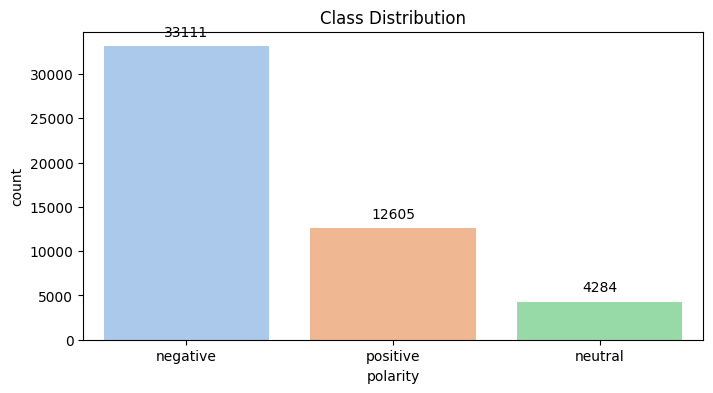

In [ ]:
plt.figure(figsize=(8, 5))
sns.set(style="whitegrid")

palette = sns.color_palette("coolwarm", n_colors=len(reviews['polarity'].unique()))

ax = sns.countplot(
    x='polarity',
    data=reviews,
    palette=palette,
    hue='polarity',
    legend=False,
    edgecolor='black'
)

plt.title('Sentiment Class Distribrution', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Data Count', fontsize=12)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=11, fontweight='bold',
                color='black', xytext=(0, 5),
                textcoords='offset points')

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

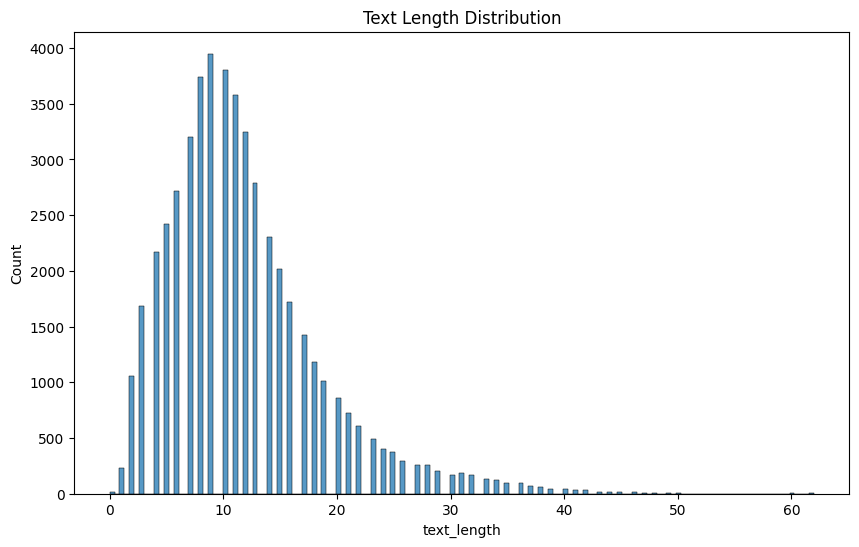

In [122]:
plt.figure(figsize=(10, 6))

reviews['text_length'] = reviews['text_akhir'].apply(lambda x: len(x.split()))
sns.histplot(reviews['text_length'])
plt.title('Text Length Distribution')
plt.show()

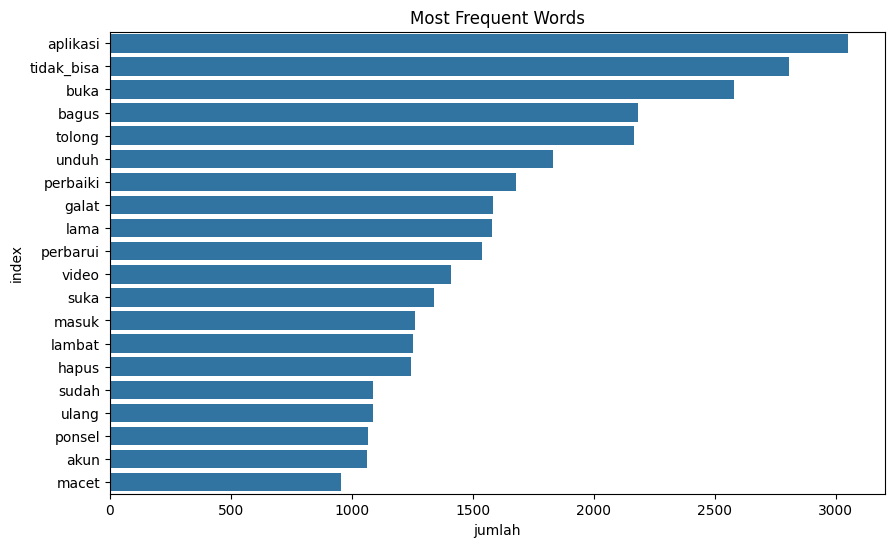

In [123]:
plt.figure(figsize=(10, 6))

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(reviews['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Most Frequent Words')
plt.show()

In [131]:
X = reviews['text_akhir']
y = reviews['polarity']

In [132]:
# encoding labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# **Skema 1 (DL)**
Training: Bidirectional LSTM

Feature Extraction: Tokenizer + Embedding Layer (Trainable)

Data Splitting: 70/15/15 

In [24]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### **Data Splitting**

In [69]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y 
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

### **Feature Extraction with Tokenizer**

In [70]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100)
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=100)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100)

X_train_pad = pad_sequences(X_train_seq, maxlen=100, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=100, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=100, padding='post')

### **Model Building and Training**

In [78]:
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

model_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-2),
    metrics=['accuracy']
)

model_lstm.build(input_shape=(None, 100))
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 64)        │     1,291,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,361,283 (5.19 MB)

 Trainable params: 1,361,283 (5.19 MB)

 Non-trainable params: 0 (0.00 B)

In [99]:
# callbacks to improve training
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

In [100]:
history1 = model_lstm.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 238s 217ms/step - accuracy: 0.9436 - loss: 0.1558 - val_accuracy: 0.9311 - val_loss: 0.2189 - learning_rate: 0.0025
Epoch 2/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 243s 200ms/step - accuracy: 0.9669 - loss: 0.0941 - val_accuracy: 0.9291 - val_loss: 0.2448 - learning_rate: 0.0025
Epoch 3/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.9781 - loss: 0.0650
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 367s 295ms/step - accuracy: 0.9786 - loss: 0.0642 - val_accuracy: 0.9311 - val_loss: 0.2965 - learning_rate: 0.0025
Epoch 4/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 371s 285ms/step - accuracy: 0.9892 - loss: 0.0355 - val_accuracy: 0.9349 - val_loss: 0.3514 - learning_rate: 0.0012
Epoch 5/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 316s 280ms/step - accuracy: 0.9937 - loss: 0.0213 - val_accuracy: 0.9351 - val_loss: 0.4278 - learning_rate: 0.0012
Epoch 6/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 320s 276ms/st

### **Model Evaluation**

In [101]:
loss1, acc1 = model_lstm.evaluate(X_train_seq, y_train, verbose=0)
print(f"\nTraining Accuracy: {acc1*100:.2f}%")

loss2, acc2 = model_lstm.evaluate(X_test_seq, y_test, verbose=0)
print(f"\nTesting Accuracy: {acc2*100:.2f}%")


Training Accuracy: 99.71%

Testing Accuracy: 93.41%


# **Skema 2 (SVM)**

Training: SVM

Feature Extraction: TF-IDF

Data Splitting: 70/30

In [102]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### **Data Splitting**

In [103]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

### **Feature Extraction with TF-IDF**

In [104]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_svm = tfidf_vectorizer.fit_transform(X_train_svm)
X_test_svm = tfidf_vectorizer.transform(X_test_svm)


### **Model Building and Training**

In [105]:
model_svm = SVC(kernel='linear', random_state=42)

model_svm.fit(X_train_svm, y_train_svm)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


### **Model Evaluation**

In [106]:
y_train_pred_svm = model_svm.predict(X_train_svm)
y_test_pred_svm = model_svm.predict(X_test_svm)

train_accuracy = accuracy_score(y_train_svm, y_train_pred_svm)
test_accuracy = accuracy_score(y_test_svm, y_test_pred_svm)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.9353
Test Accuracy: 0.9006


# **Skema 3 (LR)**

Training: Logistic Regression

Feature Extraction: TF-IDF n-gram

Data Splitting: 80/20

In [113]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

### **Data Splitting**

In [114]:
# --- Split data 80-20 ---
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### **Feature Extraction with TF-IDF n-gram**

In [118]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),     # unigram + bigram
    max_features=10000,     # batasi jumlah fitur biar efisien
    sublinear_tf=True,      # scaling log(1 + tf)
    stop_words=None         # bisa diisi 'indonesian' kalau mau
)

X_train_vec = vectorizer.fit_transform(X_train_lr)
X_test_vec = vectorizer.transform(X_test_lr)

### **Model Building and Training**

In [119]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_vec, y_train_lr)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


### **Model Evaluation**

In [120]:
y_train_pred_lr = lr.predict(X_train_vec)
y_test_pred_lr = lr.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_train_lr, y_train_pred_lr))
print("Accuracy:", accuracy_score(y_test_lr, y_test_pred_lr))

Accuracy: 0.9233
Accuracy: 0.8844
